In [85]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import os
import subprocess

In [182]:
def psql_dict(data,keys):
    return dict((key,data[key]) for key in keys)

def load_psql_file(fn):
    fin=open(fn,'r')
    keys=fin.readline()
    fin.close()
    keys= keys.split('|')
    for i in range(len(keys)): keys[i]= keys[i].strip()
    print 'keys= ',keys
    dtype=dict(formats=['f4']*len(keys), names=keys)  #holds more than 4 decimals
    #string for some KeyWords
    for kw in ['type']: dtype['formats'][keys.index('type')]= 'S4' #length 4 strings
    #only tuples to np.loadtxt
    for k in dtype.keys(): dtype[k]= tuple(dtype[k])
    #load everything
    data= np.loadtxt(fn,skiprows=2,delimiter='|',dtype=dtype)
    #make data a dictionary
    return psql_dict(data,keys)

In [187]:
dat= load_psql_file('../truth_table_results/new_deep2_f2.txt')
dat.keys()

keys=  ['zhelio', 'g', 'r', 'z', 'gflux', 'rflux', 'zflux', 'w1flux', 'w2flux', 'g_ext', 'r_ext', 'z_ext', 'w1_ext', 'w2_ext', 'type']


['z_ext',
 'gflux',
 'zflux',
 'g',
 'w1flux',
 'g_ext',
 'w2flux',
 'r',
 'r_ext',
 'w2_ext',
 'z',
 'type',
 'w1_ext',
 'rflux',
 'zhelio']

In [221]:
ind= np.all( (data['gflux']>10,data['rflux']>10,data['zflux']>10), axis=0)
# len((data['gflux'],data['gflux'],data['gflux']))
# data['gflux'][ind],data['rflux'][ind],data['zflux'][ind]

(array([ 11.05480003,  16.26250076], dtype=float32),
 array([ 13.35280037,  16.19820023], dtype=float32),
 array([ 19.31900024,  17.23950005], dtype=float32))

In [237]:
# np.all((data['type'] != 'PSF ',data['rflux']<19.35),axis=0)
 'PSF '

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,

In [245]:
def cut_neg_fluxes(data):
    ind= np.all((data['gflux']>0,data['rflux']>0, data['zflux']>0,data['w1flux']>0,data['w2flux']>0), axis=0)
    for key in data.keys(): data[key]= data[key][ind]

def flux_w_ext(data):
    for b in ['g', 'r', 'z','w1','w2']:
        data[b+'flux_ext']= data[b+'flux']/data[b+'_ext']

def flux_to_mag_ab(data):
    for b in ['g', 'r', 'z','w1','w2']:
        data[b+'mag']= 22.5 -2.5*np.log10(data[b+'flux_ext'])

def BGS_cuts(data):
    data['bgs']= np.all((data['type'] != 'PSF ',\
                         data['rmag']<19.35),\
                        axis=0)

def LRG_cuts(data):
    data['lrg']= np.all((data['rmag']<23.0,\
                       data['zmag']<20.56,\
                       data['w1mag']<19.35,\
                       data['rmag']-data['zmag']> 1.6,\
                       data['rmag']-data['w1mag']> 1.33*(data['rmag']-data['zmag']) -0.33),\
                        axis=0)

def ELG_cuts(data):
    data['elg']= np.all((data['rmag']<23.4,\
                       data['rmag']-data['zmag']> 0.3,\
                        data['rmag']-data['zmag']< 1.5,\
                       data['gmag']-data['rmag']< 1.0*(data['rmag']-data['zmag']) -0.2,\
                        data['gmag']-data['rmag']< -1.0*(data['rmag']-data['zmag']) +1.2),\
                        axis=0)

def QSO_cuts(data):
    wavg= 0.75*data['w1mag']+ 0.25*data['w2mag']
    data['qso']= np.all((data['type']=='PSF ',\
                        data['rmag']<23.0,
                       data['gmag']-data['rmag']< 1.0,\
                        data['rmag']-data['zmag']> -0.3,\
                       data['rmag']-data['zmag']< 1.1,\
                        data['rmag']-wavg> 1.2*(data['gmag']-data['rmag']) -0.4),\
                        axis=0)

def get_targets(data):
    cut_neg_fluxes(data)
    flux_w_ext(data)
    flux_to_mag_ab(data)
    #indices for each class
    BGS_cuts(data)
    LRG_cuts(data)
    ELG_cuts(data)
    QSO_cuts(data)



In [246]:
get_targets(dat)

In [257]:
dat['zhelio'][dat['elg']]

array([ 0.50172698,  0.97452301,  0.89871001,  1.05328   ,  1.33410001,
        1.28351998,  0.99748403,  0.98006701,  2.09682012,  1.16363001,
        1.11034   ,  0.844814  ,  0.96263301,  1.11342001,  0.90312898,
        1.23327005,  0.82872403,  1.33039999,  1.03795004,  1.12434995,
        1.27366996,  0.79148299,  0.75993699,  1.32264996,  1.00803006,
        1.19379997,  0.841245  ,  1.04269004,  0.78568399,  0.77584898,
        1.27040005,  0.967897  ,  0.76860702,  0.73080802,  1.12190998,
        0.803518  ,  1.98473001,  0.86497903,  0.78990602,  0.95128202,
        1.08097994,  0.79636401,  1.66356003,  1.35900998,  1.4562    ,
        1.89064002,  1.23801994,  1.03161001,  0.945912  ,  1.23062003,
        0.77931398,  1.27168   ], dtype=float32)

In [103]:
for i in range(len(line)):
    if i>=2 and i <=4: line[i]='dr1_'+line[i]
    elif i>=5 and i <=7: line[i]='dr2_'+line[i]
print 'keys= ',line

keys=  ['zhelio', 'g', 'dr1_r', 'dr1_z', 'dr1_gflux', 'dr2_rflux', 'dr2_zflux']


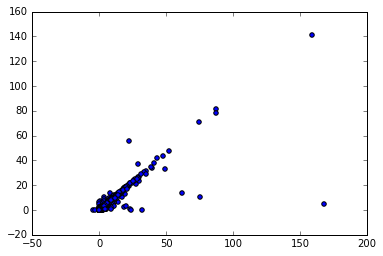

In [47]:
plt.scatter(data['dr1_gflux'],data['dr2_gflux'])

In [48]:
from modules.plot.multi_panels import multi_plot

In [59]:
def row_col_plot(nrow,ncol,x,y,scatter=False,indices=None,fname='test.png',titles=None,xlim=False,ylim=False,logx=False,logy=False):
    '''x,y have shape (nrow*ncol,values,extra_axis)
    extra_axis is not necessary if plotting single line per plot otherwise extra axis 
    contains those lines'''
    assert(nrow == 1 or ncol == 1)
    assert(x.shape[0] == nrow*ncol)
    w,h=20,10
    fig,axes=plt.subplots(nrow,ncol,figsize=(w,h))
    ax=axes.flatten()
    plt.subplots_adjust(hspace=0,wspace=0)
    cnt=0
    for i in range(len(ax)):
        if len(x.shape) == 3: #exta_axis, multiple lines per plot
            for extra in range(x.shape[2]):
                #some values may be nan or inf if some lines longer than others
                iuse= np.isfinite(x[cnt,:,extra])
                if scatter: ax[i].scatter(x[cnt,iuse,extra],y[cnt,iuse,extra])
                else: ax[i].plot(x[cnt,iuse,extra],y[cnt,iuse,extra])
        else: 
            if scatter: ax[i].scatter(x[cnt,:],y[cnt,:])
            else: ax[i].plot(x[cnt,:],y[cnt,:])
        if titles is not None: ax[i].set_title('%s' % titles[cnt])
        cnt+=1
    for i in range(len(ax)):
        if xlim: ax[i].set_xlim(xlim[0],xlim[1])
        if ylim: ax[i].set_ylim(ylim[0],ylim[1])
        if logx: ax[i].set_xscale('log')
        if logy: ax[i].set_yscale('log')
#     for i in range(len(ax)):
#         if r != range(nrow)[-1]: ax[i].xaxis.set_major_formatter(plt.NullFormatter())
#         if c != 0: ax[i].yaxis.set_major_formatter(plt.NullFormatter())
#     plt.savefig(fname)
#     plt.close()

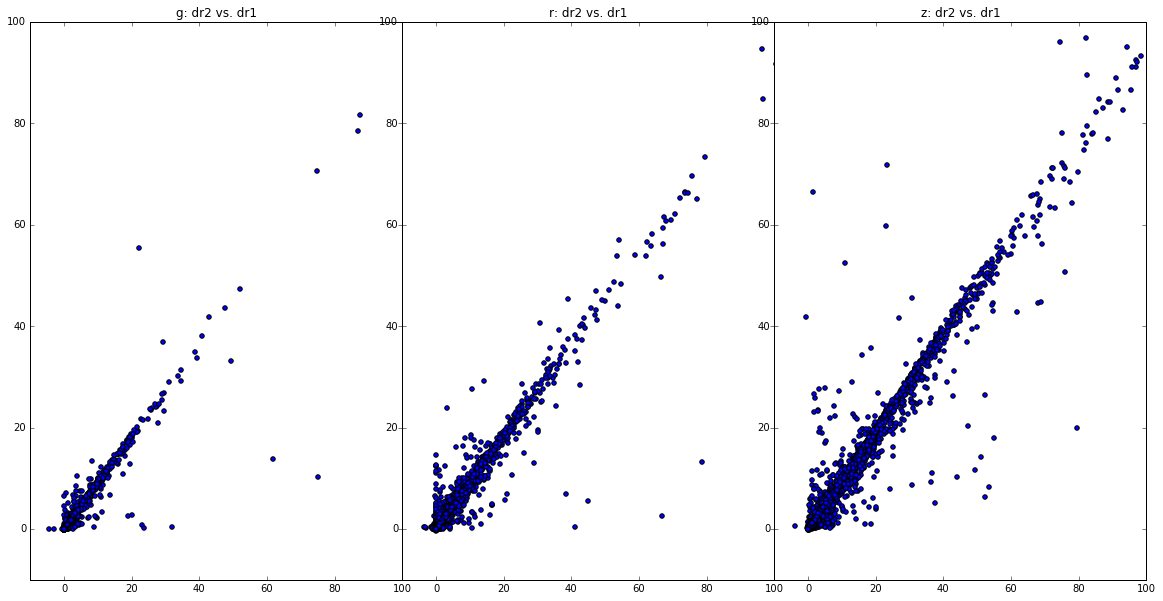

In [62]:
x=np.zeros( (3,len(data['dr1_gflux']),2) )
y=x.copy()
for i,dr1,dr2 in zip(range(3),
                     ['dr1_gflux', 'dr1_rflux', 'dr1_zflux'],
                    ['dr2_gflux', 'dr2_rflux', 'dr2_zflux']):
    x[i,:,0]= data[dr1]
#     x[i,:,1]= data[dr1] #drawing straight line
    y[i,:,0]= data[dr2]
#     y[i,:,1]= x[i,:,1]
titles=['%s: dr2 vs. dr1' % b for b in ['g','r','z']]
row_col_plot(1,3,x,y,titles=titles,scatter=True,ylim=[-10,100],xlim=[-10,100])

(array([  5.00000000e+00,   2.80000000e+01,   1.87000000e+02,
          6.98000000e+02,   1.62600000e+03,   3.21600000e+03,
          5.35400000e+03,   5.32100000e+03,   6.88000000e+02,
          1.70000000e+01]),
 array([  5.51035528,   8.06474453,  10.61913378,  13.17352303,
         15.72791228,  18.28230153,  20.83669078,  23.39108003,
         25.94546928,  28.49985853,  31.05424778]),
 <a list of 10 Patch objects>)

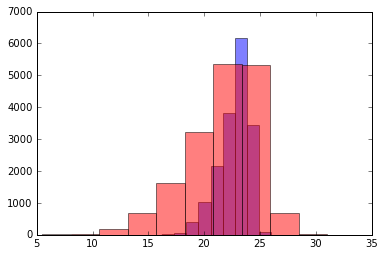

In [84]:
plt.hist(data['mag_isocor'],color='b',alpha=0.5)
mags= -2.5*np.log(data['dr1_zflux'][ data['dr1_zflux'] > 0 ])
plt.hist(mags+22.5,color='r',alpha=0.5)

(array([    7.,    40.,   211.,   707.,  1779.,  4467.,  6879.,  2139.,
          561.,    47.]),
 array([ 16.93814952,  18.08892264,  19.23969576,  20.39046887,
         21.54124199,  22.69201511,  23.84278822,  24.99356134,
         26.14433446,  27.29510757,  28.44588069]),
 <a list of 10 Patch objects>)

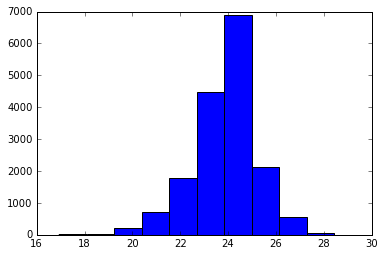

In [82]:
# plt.hist( flux_to_mag(data['dr1_gflux']))
mags= -2.5*np.log10(data['dr1_gflux'][ data['dr1_gflux'] > 0 ])
plt.hist(mags+22.5)

(array([  5.00000000e+00,   2.80000000e+01,   1.87000000e+02,
          6.98000000e+02,   1.62600000e+03,   3.21600000e+03,
          5.35400000e+03,   5.32100000e+03,   6.88000000e+02,
          1.70000000e+01]),
 array([-16.98964472, -14.43525547, -11.88086622,  -9.32647697,
         -6.77208772,  -4.21769847,  -1.66330922,   0.89108003,
          3.44546928,   5.99985853,   8.55424778]),
 <a list of 10 Patch objects>)

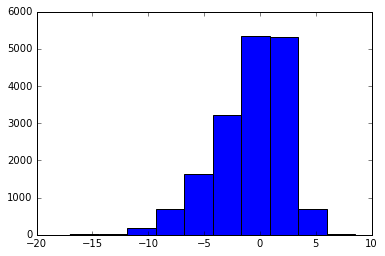

In [81]:
mags= -2.5*np.log(data['dr1_zflux'][ data['dr1_zflux'] > 0 ])
plt.hist(mags)

In [80]:
-2.5*np.log(1e-3)

17.269388197455342

In [86]:
bashCommand = "date"
process = subprocess.Popen(bashCommand.split(), stdout=subprocess.PIPE)
output = process.communicate()[0]
output

'Wed Feb 17 15:42:33 PST 2016\n'

In [99]:
a='deep2_f2'
a.startswith('deep2')

True

In [98]:
output[output.find(':')-2:].replace(' ','').strip().replace(':','-')

'15-42-33PST2016'

In [91]:
output[13:]

':42:33 PST 2016\n'